In [18]:
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

from imblearn.over_sampling import RandomOverSampler

In [19]:
teams_df = pd.read_csv("scaled_teams_itm.csv")
points_df = pd.read_csv("scaled_points.csv")
scaled_games_df = pd.read_csv("scaled_games.csv")

In [20]:
teams_df = teams_df[['year', 'abbrev', 'id', 'record.overall.wins', 'record.overall.losses', 'record.overall.pointsFor', 'record.overall.pointsAgainst', 'scaled_pointsFor', 'scaled_pointsAgainst', 'itm' ]]
teams_df.rename(columns={'record.overall.wins': 'wins', 'record.overall.losses': 'losses', 'record.overall.pointsFor': 'pointsFor', 'record.overall.pointsAgainst': 'pointsAgainst'}, inplace=True)
#teams_df.set_index(['year', 'id'], inplace=True)
teams_df.head()

,year,abbrev,id,wins,losses,pointsFor,pointsAgainst,scaled_pointsFor,scaled_pointsAgainst,itm
0,2020,#1,1,11,2,1899.1,1624.8,0.939520,-0.857105,NaN
1,2020,GUY,2,8,5,1805.0,1757.0,0.482095,0.541343,NaN
2,2020,Seth,3,6,7,1552.3,1714.6,-0.746294,0.092824,NaN
3,2020,TMB,7,7,6,1636.3,1562.1,-0.337965,-1.520362,NaN
4,2020,Mill,9,4,9,1586.9,1720.2,-0.578101,0.152063,NaN


In [21]:
points_df.head()

,year,team_id,diff,scaled_diff
0,2018,1,-1409.7,-2.356939
1,2018,2,-454.3,0.581335
2,2018,3,-321.4,0.990060
3,2018,7,-362.9,0.862430
4,2018,9,-546.5,0.297779


In [22]:
#with_points = teams_df.join(points_df.set_index(['year', 'team_id']), how='inner', on=['year', 'team_id'])
with_points = teams_df.merge(points_df, left_on=['year', 'id'], right_on=['year', 'team_id'])

In [23]:
with_points.head()

,year,abbrev,id,wins,losses,pointsFor,pointsAgainst,scaled_pointsFor,scaled_pointsAgainst,itm,team_id,diff,scaled_diff
0,2020,#1,1,11,2,1899.1,1624.8,0.939520,-0.857105,NaN,1,-517.4,-0.529538
1,2020,GUY,2,8,5,1805.0,1757.0,0.482095,0.541343,NaN,2,-284.9,-0.151037
2,2020,Seth,3,6,7,1552.3,1714.6,-0.746294,0.092824,NaN,3,-464.4,-0.443256
3,2020,TMB,7,7,6,1636.3,1562.1,-0.337965,-1.520362,NaN,7,-357.9,-0.269878
4,2020,Mill,9,4,9,1586.9,1720.2,-0.578101,0.152063,NaN,9,-285.1,-0.151363


In [24]:
with_games = with_points.merge(scaled_games_df, left_on=['year', 'id'], right_on=['year', 'Team'])

In [25]:
with_games.head()

,year,abbrev,id,wins,losses,pointsFor,pointsAgainst,scaled_pointsFor,scaled_pointsAgainst,itm,team_id,diff,scaled_diff,Team,lucky_win,unlucky_loss,scaled_lucky_win,scaled_unlucky_loss
0,2020,#1,1,11,2,1899.1,1624.8,0.939520,-0.857105,NaN,1,-517.4,-0.529538,1,0,0,-1.365473,-1.893506
1,2020,GUY,2,8,5,1805.0,1757.0,0.482095,0.541343,NaN,2,-284.9,-0.151037,2,0,1,-1.365473,-0.811503
2,2020,Seth,3,6,7,1552.3,1714.6,-0.746294,0.092824,NaN,3,-464.4,-0.443256,3,3,2,1.526117,0.270501
3,2020,TMB,7,7,6,1636.3,1562.1,-0.337965,-1.520362,NaN,7,-357.9,-0.269878,7,3,1,1.526117,-0.811503
4,2020,Mill,9,4,9,1586.9,1720.2,-0.578101,0.152063,NaN,9,-285.1,-0.151363,9,2,3,0.562254,1.352504


In [26]:
just_itm = with_games.dropna()
X = just_itm[['wins', 'losses', 'scaled_pointsFor', 'scaled_pointsAgainst', 'scaled_diff', 'scaled_lucky_win', 'scaled_unlucky_loss']]
y = just_itm['itm']

ros_over = RandomOverSampler(random_state=10)
os_X, os_y = ros_over.fit_resample(X,  y)

X_train, X_test, y_train, y_test = train_test_split(os_X, os_y, test_size = 0.20)

In [27]:
mlp = MLPClassifier(hidden_layer_sizes=(10, 10, 10, 10), max_iter=1000)
mlp.fit(X_train, y_train.values.ravel())

MLPClassifier(hidden_layer_sizes=(10, 10, 10, 10), max_iter=1000)

In [28]:
cur_teams = with_games[with_games['itm'].isna()]
X_cur = cur_teams[['wins', 'losses', 'scaled_pointsFor', 'scaled_pointsAgainst', 'scaled_diff', 'scaled_lucky_win', 'scaled_unlucky_loss']]

In [29]:
predictions = mlp.predict(X_test)

In [30]:
predictions

array([0., 0., 1., 1., 0., 0., 1., 1.])

In [31]:
print(confusion_matrix(y_test,predictions))
print(classification_report(y_test,predictions))

[[4 1]
 [0 3]]
              precision    recall  f1-score   support

         0.0       1.00      0.80      0.89         5
         1.0       0.75      1.00      0.86         3

    accuracy                           0.88         8
   macro avg       0.88      0.90      0.87         8
weighted avg       0.91      0.88      0.88         8



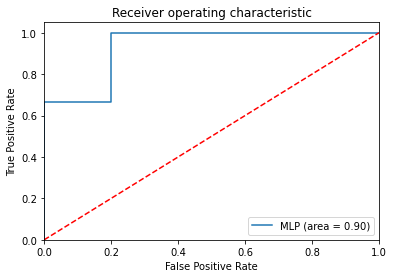

In [32]:
ml_roc_auc = roc_auc_score(y_test, mlp.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, mlp.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='MLP (area = %0.2f)' % ml_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")

In [33]:
cur_predictions = mlp.predict(X_cur)

In [34]:
cur_teams["pred_itm"] = cur_predictions
cur_teams[['id', 'abbrev', 'wins', 'losses', 'pred_itm']].head(12)

,id,abbrev,wins,losses,pred_itm
0,1,#1,11,2,1.0
1,2,GUY,8,5,1.0
2,3,Seth,6,7,0.0
3,7,TMB,7,6,0.0
4,9,Mill,4,9,0.0
5,10,TWS,2,11,0.0
6,12,BBc,9,4,1.0
7,13,#50%,7,6,0.0
8,15,faq,10,3,0.0
9,16,JJJ,5,8,0.0
